In [28]:
import cv2
import numpy as np

In [29]:
from datetime import datetime
import pandas as pd
import os
import glob

PATH = "/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/detectors/blur/tsi/"
all_images = glob.glob("../../../dataset/valid/*.JPG")

In [30]:
print(all_images[:5])

['../../../dataset/valid/N239001014.JPG', '../../../dataset/valid/N230201570.JPG', '../../../dataset/valid/N230101709.JPG', '../../../dataset/valid/N230701220.JPG', '../../../dataset/valid/N230301766.JPG']


## Focus threshold set to 0.02

In [31]:
def is_focused(TSI):
    # Rescale the TSI to the range [0, 100]
    if TSI > 0.02:
        return True
    return False

## Logger

In [32]:
def logger(image, blur_amount, compliance_score1, compliance_score2):
    time_str = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    data = {
        'log_time': [time_str],
        'image': [image],
        'gaussian_blur': [blur_amount],
        'compliance_score1': [compliance_score1],
        'is_focused1': [is_focused(compliance_score1)],
        'compliance_score2': [compliance_score2],
        'is_focused2': [is_focused(compliance_score2)],
        'difference': [compliance_score1 - compliance_score2]
    }

    # Check if the file exists
    file_exists = os.path.isfile(PATH + 'blur_logs_tsi.csv')

    # If the file doesn't exist, create it with the header
    mode = 'w' if not file_exists else 'a'
    header = False if file_exists else True

    df_headers = pd.DataFrame(data)
    df_headers.to_csv(PATH + 'blur_logs_tsi.csv', mode=mode, index=False, header=header)

In [33]:
def normalize_gray_levels(image):
    # Calculate the gray level range
    min_val, max_val = np.percentile(image, (1, 99))

    # Normalize the gray levels
    normalized_image = 255 * (image - min_val) / (max_val - min_val)
    normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

    return normalized_image

In [34]:
def compute_TSI(image, percentage, resolution):
    # Normalize gray levels
    normalized_image = normalize_gray_levels(image)

    # Sharpening filter
    sharpening_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) / 9
    convolved_image = cv2.filter2D(normalized_image, -1, sharpening_filter)
    convolved_image = np.abs(convolved_image)

    # Calculate the number of pixels for the top percentage
    u, v = image.shape[:2]
    num_pixels = int(percentage / 100 * u * v)

    # Get the top percentage pixels
    sorted_pixels = np.sort(convolved_image.flatten())[::-1][:num_pixels]

    # Calculate TSI
    TSI = np.sum(sorted_pixels) / (8/9 * 255 * percentage * u * v)

    return TSI

In [35]:
def calculate_compliance_score(TSI):
    # Rescale the TSI to the range [0, 100]
    compliance_score = (TSI - 0) * (100 - 0) / (1 - 0)

    return compliance_score

## Run for batch

In [36]:
original_vals = []
gaussian_blur3_vals = []
gaussian_blur5_vals = []
gaussian_blur7_vals = []

In [37]:
# time duration
start_time = datetime.now()

for j in range(0, int(len(all_images))):
    image_name = all_images[j]
    print(image_name)

    # Load the image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Failed to load the image. Please check the image path.")

    # Set the parameters
    percentage = 10  # Percentage of top sharpening responses to consider
    resolution = 500  # Scanner nominal output resolution

    # Calculate the TSI
    TSI = compute_TSI(image, percentage, resolution)
    original_vals.append(TSI)

    for i in range(3, 8, 2):
        TSI2 = compute_TSI(cv2.GaussianBlur(image, (i, i), 0), percentage, resolution)
        if i == 3:
            gaussian_blur3_vals.append(TSI2)
        elif i == 5:
            gaussian_blur5_vals.append(TSI2)
        elif i == 7:
            gaussian_blur7_vals.append(TSI2)
        # Calculate the compliance score
        compliance_score = calculate_compliance_score(TSI)
        compliance_score2 = calculate_compliance_score(TSI2)

        logger(image_name, i, compliance_score, compliance_score2)


end_time = datetime.now()
print('Unit: seconds')
print('Duration: {}'.format(end_time - start_time))
print('Duration per image: {}'.format((end_time - start_time)/len(all_images)))


../../../dataset/valid/N239001014.JPG
../../../dataset/valid/N230201570.JPG
../../../dataset/valid/N230101709.JPG
../../../dataset/valid/N230701220.JPG
../../../dataset/valid/N230301766.JPG
../../../dataset/valid/N230601354.JPG
../../../dataset/valid/N230601432.JPG
../../../dataset/valid/N230101669.JPG
../../../dataset/valid/N230101899.JPG
../../../dataset/valid/N230601368.JPG
../../../dataset/valid/N231601055.JPG
../../../dataset/valid/N230101696.JPG
../../../dataset/valid/N230601630.JPG
../../../dataset/valid/N230501688.JPG
../../../dataset/valid/N231701531.JPG
../../../dataset/valid/N239001148.JPG
../../../dataset/valid/N230201404.JPG
../../../dataset/valid/N230201439.JPG
../../../dataset/valid/N230201405.JPG
../../../dataset/valid/N231701524.JPG
../../../dataset/valid/N238100624.JPG
../../../dataset/valid/N230101683.JPG
../../../dataset/valid/N231501013.JPG
../../../dataset/valid/N231501007.JPG
../../../dataset/valid/N231701726.JPG
../../../dataset/valid/N230601427.JPG
../../../dat

## Plot the histogram

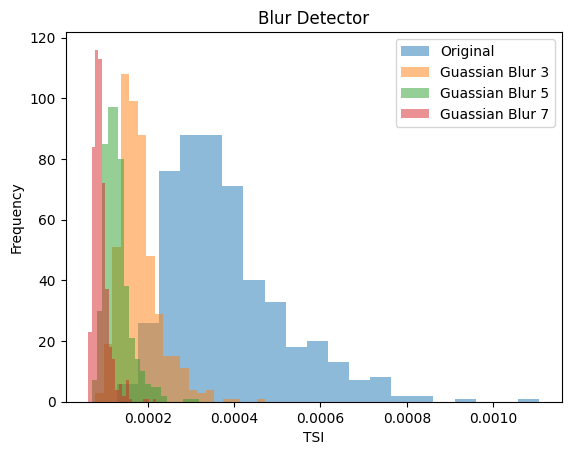

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the histograms
n_bins = 20  # Number of bins in the histogram
ax.hist(original_vals, bins=n_bins, alpha=0.5, label='Original')
ax.hist(gaussian_blur3_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 3')
ax.hist(gaussian_blur5_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 5')
ax.hist(gaussian_blur7_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 7')

# Add labels and title
ax.set_xlabel('TSI')
ax.set_ylabel('Frequency')
ax.set_title('Blur Detector')

# Add legend
ax.legend()
# plt.savefig(PATH + 'tsi_histrogram.png')

# Show the plot
plt.show()

## Error Analysis

In [44]:
THRESHOLD = 0.00026

In [45]:
from tabulate import tabulate

original_size = len(original_vals)
original_vals_copy = [i for i in original_vals if i > THRESHOLD]
filtered_size = len(original_vals_copy)

blur3_incorrect_size = len([i for i in gaussian_blur3_vals if i > THRESHOLD])
blur5_incorrect_size = len([i for i in gaussian_blur5_vals if i > THRESHOLD])
blur7_incorrect_size = len([i for i in gaussian_blur7_vals if i > THRESHOLD])

headers = ["GBlur Factor", "Incorrect Images", "Incorrect Percentage"]

table = [
    ["Original-Missing", filtered_size, f"{(original_size-filtered_size)/original_size*100}%"],
    ["GBlur 3", blur3_incorrect_size, f"{blur3_incorrect_size/original_size*100}%"],
    ["GBlur 5", blur5_incorrect_size, f"{blur5_incorrect_size/original_size*100}%"],
    ["GBlur 7", blur7_incorrect_size, f"{blur7_incorrect_size/original_size*100}%"]
]

print(tabulate(table, headers, tablefmt="simple_grid"))

print(f"Original size: {original_size}")
print(f"Filtered size: {filtered_size}")
print(f"Filtered percentage: {filtered_size/original_size*100}%")

┌──────────────────┬────────────────────┬────────────────────────┐
│ GBlur Factor     │   Incorrect Images │ Incorrect Percentage   │
├──────────────────┼────────────────────┼────────────────────────┤
│ Original-Missing │                412 │ 17.599999999999998%    │
├──────────────────┼────────────────────┼────────────────────────┤
│ GBlur 3          │                 36 │ 7.199999999999999%     │
├──────────────────┼────────────────────┼────────────────────────┤
│ GBlur 5          │                  3 │ 0.6%                   │
├──────────────────┼────────────────────┼────────────────────────┤
│ GBlur 7          │                  0 │ 0.0%                   │
└──────────────────┴────────────────────┴────────────────────────┘
Original size: 500
Filtered size: 412
Filtered percentage: 82.39999999999999%


## Filtered Histogram

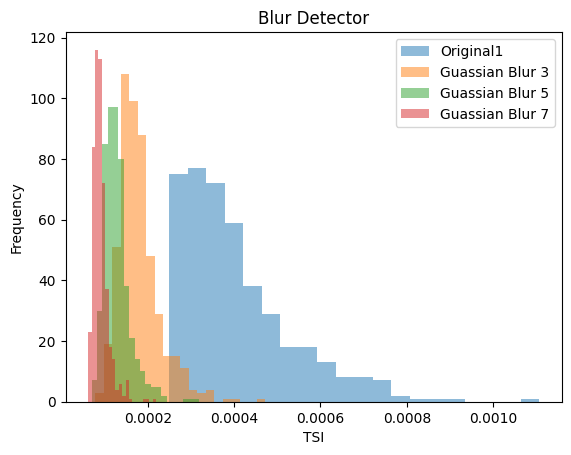

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the histograms
n_bins = 20  # Number of bins in the histogram
# ax.hist([x for x in original_vals if x > 0.0002], bins=n_bins, alpha=0.5, label='Original')
ax.hist(original_vals_copy, bins=n_bins, alpha=0.5, label='Original1')
ax.hist(gaussian_blur3_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 3')
ax.hist(gaussian_blur5_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 5')
ax.hist(gaussian_blur7_vals, bins=n_bins, alpha=0.5, label='Guassian Blur 7')

# Add labels and title
ax.set_xlabel('TSI')
ax.set_ylabel('Frequency')
ax.set_title('Blur Detector')

# Add legend
ax.legend()
plt.savefig(PATH + 'tsi_histrogram.png')

# Show the plot
plt.show()

## Run for single image

In [ ]:
# Load the image
image = cv2.imread('/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/invalid/blur/110_IPHONE-7_S.jpeg', cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Failed to load the image. Please check the image path.")

# Set the parameters
percentage = 10  # Percentage of top sharpening responses to consider
resolution = 500  # Scanner nominal output resolution

# Calculate the TSI
TSI = compute_TSI(image, percentage, resolution)

# Calculate the compliance score
compliance_score = calculate_compliance_score(TSI)

print(f"Compliance score: {compliance_score}")
